# Задача о прогнозировании урожайности культур

In [1]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyodbc
from IPython.display import display
import arcgis
from arcgis.gis import GIS
import geopy
from geopy.distance import geodesic
import pyxlsb
import datetime
import time

C:\ProgramData\Anaconda3\lib\site-packages\arcgis\features\_data\geodataset\utils.py:16: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  pd.datetime,


# Функции

In [2]:
#Переводим строки с координатами из базы данных в датафрейм с долготой и широтой
def strToCoord(str):
    points = str.split('}, {\'lng\': ')
    points[0] = points[0][9:]
    points[-1] = points[-1][:-2]
    for i in range(len(points)):
        points[i] = points[i].split(', \'lat\': ')
    return pd.DataFrame(points, columns = ['longitude','latitude'])

#Рисуем точки на карте
def drawOnMap(dots):
    gis = GIS()
    test_map = gis.map(location = (dots.loc[0]['latitude'],dots.loc[0]['longitude']), zoomlevel = 15)
    i = 0
    while i < len(dots):
        field = gis.content.import_data(dots.loc[i:i+1000])
        test_map.add_layer(field)
        i += 1000
    return test_map

#Преобразования для погоды
def editWeather(data):
    del data['Po']
    del data['P']
    del data['Pa']
    del data['U']
    del data['DD']
    del data['ff3']
    del data['N']
    del data['Cl']
    del data['Nh']
    del data['H']
    del data['Cm']
    del data['Ch']
    del data['VV']
    del data['E']
    del data['E\'']
    return data

#Добавляем координаты метеостанции
def editMeteo(data, long, lat, city):
    data.loc[len(data)] = [long, lat, city]
    return data

#Убираем лишнее из культур
def editCrop(data):
    del data['createdAt']
    del data['cropId']
    del data['cropTypeId']
    del data['departmentId']
    del data['finishedHarvestingAt']
    del data['finishedSowingAt']
    del data['seasonId']
    del data['seedVariety']
    del data['soilTypeId']
    del data['id']
    del data['importCropName']
    del data['importCropSort']
    del data['indicators']
    del data['lastCropId']
    del data['lastHarvestedAt']
    del data['lastSeededAt']
    del data['productionPurpose']
    del data['productivity']
    del data['score']
    del data['startedHarvestingAt']
    del data['startedSowingAt']
    del data['type']
    del data['updatedAt']
    del data['varietyId']
    del data['legalArea']
    del data['legalId']
    del data['plot']
    del data['meteoStationId']
    del data['number']
    return(data)

#Ищем ближайшую метеостанцию к точке
def nearestMeteo(lat, lng, meteo):
    min_dist = 50000
    nearest = 'Город, которого нет'
    for i in range(len(meteo)):
        dist = geodesic((lat,lng), (meteo.loc[i]['latitude'],meteo.loc[i]['longitude'],)).km
        if dist<min_dist:
            min_dist = dist
            nearest = meteo.loc[i]['city']
    return nearest

#Считаем сумму активных температур, startDate строка вида 'DD.MM.YYYY'
#Активной по умолчанию считается температура, большая 5 градусов
def activeTemp(weather, startDate, border = 5):
    total = 0
    found_day = False
    today = weather.iloc[:,0][0][:10]
    today_temp = []
    for i in range(len(weather)):
        if weather.iloc[:,0][i][:10] == today:
            today_temp.append(weather['T'].iloc[i])
        else:
            mean_temp = np.mean(today_temp)
            if mean_temp > border:
                total += mean_temp
            today = weather.iloc[:,0][i][:10]
            today_temp = [weather['T'].iloc[i]]
        if startDate in weather.iloc[:,0][i]:
            found_day = True
        if found_day == True and startDate not in weather.iloc[:,0][i]:
            break
    return total

#Считаем сумму накопленных осадков, startDate строка вида 'DD.MM.YYYY'
def accumPrecip(weather, startDate):
    total = 0
    today = weather.iloc[:,0][0][:10]
    for i in range(len(weather)):
        try:
            if weather.loc[i,'RRR'] > 0:
                total += weather.loc[i,'RRR']
        except TypeError:
            continue
        if startDate in weather.iloc[:,0][i]:
            break
    return total

#Передаём урожайности, ищем медиану и среднее значение, возвращаем максимум (учитываются пустые значения)
def productivity(prods):
    new_prods = []
    for i in range(len(prods)):
        if prods[i] != None:
            new_prods.append(prods[i])
    return max(np.median(new_prods), np.mean(new_prods))

#Старый номер участка в новый
def oldToNew(number, base):
    #try:
        if str(base.loc[base['Полный номер поля (старый)'] == str(number)]['Полный номер поля'].values) != '[]':
            return base.loc[base['Полный номер поля (старый)'] == str(number)]['Полный номер поля'].values[0]
        else:
            return base.loc[base['Полный номер поля (старый)'].str.contains(str(number))].head(1)['Полный номер поля'].values[0]
    #except IndexError:
        return base.loc[base['Полный номер поля (старый)'].str.contains(str(number))].head(1)['Полный номер поля'].values[0]

# Получение данных с сервера

In [3]:
#Получаем токен для выполнения команд на сервере
#headers = {
#    'Content-Type': 'application/json',
#    'Accept': 'application/json', 
#}

#credentials = '{ \n \t"email": "", \n \t"password": "" \n }'

#response = requests.post('https://ekoniva-testing.myddns.rocks/api/AppUsers/login', headers=headers, data=credentials)
#token = response.json()['id']
#response

In [4]:
###Загружаем FarmLands
#url = 'https://ekoniva-testing.myddns.rocks/api/FarmLands'
#data = {
#    'Authorization': token
#}
#response = requests.get(url, headers = data)
#data = response.json()
#json_string = json.dumps(data)
#df_farm = pd.read_json(json_string)

In [5]:
df_farm = pd.read_csv('farm.csv')

In [6]:
#Озимая пшеница
oz = df_farm.loc[df_farm['cropShortName'] == 'Озимая пшеница'].reset_index().drop(columns = ['index'])
#Ярова пшеница
yar =  df_farm.loc[df_farm['cropShortName'] == 'Яровая пшеница'].reset_index().drop(columns = ['index'])
#Люцерна
luc = df_farm.loc[df_farm['cropShortName'] == 'Люцерна'].reset_index().drop(columns = ['index'])
#Соя
soy = df_farm.loc[df_farm['cropShortName'] == 'Соя'].reset_index().drop(columns = ['index'])
#Начинаем формировать датасет, объединяя всё предыдущее
df_final = pd.concat([editCrop(oz),editCrop(yar),editCrop(soy),editCrop(luc)])

# Загружаем данные о погоде в отдельные переменные

In [7]:
weatherKursk1 = pd.read_excel('kursk0511.xls', skiprows=6)
weatherKursk2 = pd.read_excel('kursk1220.xls', skiprows=6)
weatherKursk = pd.concat([weatherKursk2,weatherKursk1], ignore_index=True)
weatherKursk = editWeather(weatherKursk)

In [8]:
weatherVoronezh = pd.read_excel('Voronezh.xls')
del weatherVoronezh['Unnamed: 0']
weatherVoronezh = editWeather(weatherVoronezh)

In [9]:
weatherAksakovo1 = pd.read_excel('aksakovo0914.xls', skiprows=6)
weatherAksakovo2 = pd.read_excel('aksakovo1520.xls', skiprows=6)
weatherAksakovo = pd.concat([weatherAksakovo2,weatherAksakovo1], ignore_index=True)
weatherAksakovo = editWeather(weatherAksakovo)

In [10]:
weatherAnna1 = pd.read_excel('anna0511.xls', skiprows=6)
weatherAnna2 = pd.read_excel('anna1220.xls', skiprows=6)
weatherAnna = pd.concat([weatherAnna2,weatherAnna1], ignore_index=True)
weatherAnna = editWeather(weatherAnna)

In [11]:
weatherAromashevo = pd.read_excel('aromashevo.xls', skiprows=6)
weatherAromashevo = editWeather(weatherAromashevo)

In [12]:
weatherBugulma1 = pd.read_excel('bugulma0511.xls', skiprows=6)
weatherBugulma2 = pd.read_excel('bugulma1220.xls', skiprows=6)
weatherBugulma = pd.concat([weatherBugulma2,weatherBugulma1], ignore_index=True)
weatherBugulma = editWeather(weatherBugulma)

In [13]:
weatherGagarin1 = pd.read_excel('gagarin0511.xls', skiprows=6)
weatherGagarin2 = pd.read_excel('gagarin1220.xls', skiprows=6)
weatherGagarin = pd.concat([weatherGagarin2,weatherGagarin1], ignore_index=True)
weatherGagarin = editWeather(weatherGagarin)

In [14]:
weatherKamennayaStep1 = pd.read_excel('kamennaya_step0511.xls', skiprows=6)
weatherKamennayaStep2 = pd.read_excel('kamennaya_step1220.xls', skiprows=6)
weatherKamennayaStep = pd.concat([weatherKamennayaStep2,weatherKamennayaStep1], ignore_index=True)
weatherKamennayaStep = editWeather(weatherKamennayaStep)

In [15]:
weatherKingisepp1 = pd.read_excel('kingisepp0511.xls', skiprows=6)
weatherKingisepp2 = pd.read_excel('kingisepp1220.xls', skiprows=6)
weatherKingisepp = pd.concat([weatherKingisepp2,weatherKingisepp1], ignore_index=True)
weatherKingisepp = editWeather(weatherKingisepp)

In [16]:
weatherKlyavlino1 = pd.read_excel('klyavlino0814.xls', skiprows=6)
weatherKlyavlino2 = pd.read_excel('klyavlino1520.xls', skiprows=6)
weatherKlyavlino = pd.concat([weatherKlyavlino2,weatherKlyavlino1], ignore_index=True)
weatherKlyavlino = editWeather(weatherKlyavlino)

In [17]:
weatherLiski1 = pd.read_excel('liski0511.xls', skiprows=6)
weatherLiski2 = pd.read_excel('liski1220.xls', skiprows=6)
weatherLiski = pd.concat([weatherLiski2,weatherLiski1], ignore_index=True)
weatherLiski = editWeather(weatherLiski)

In [18]:
weatherMaslyanino1 = pd.read_excel('maslyanino0511.xls', skiprows=6)
weatherMaslyanino2 = pd.read_excel('maslyanino1220.xls', skiprows=6)
weatherMaslyanino = pd.concat([weatherMaslyanino2,weatherMaslyanino1], ignore_index=True)
weatherMaslyanino = editWeather(weatherMaslyanino)

In [19]:
weatherMikhnevo1 = pd.read_excel('mikhnevo1316.xls', skiprows=6)
weatherMikhnevo2 = pd.read_excel('mikhnevo1720.xls', skiprows=6)
weatherMikhnevo = pd.concat([weatherMikhnevo2,weatherMikhnevo1], ignore_index=True)
weatherMikhnevo = editWeather(weatherMikhnevo)

In [20]:
weatherMosalsk1 = pd.read_excel('mosalsk0511.xls', skiprows=6)
weatherMosalsk2 = pd.read_excel('mosalsk1220.xls', skiprows=6)
weatherMosalsk = pd.concat([weatherMosalsk2,weatherMosalsk1], ignore_index=True)
weatherMosalsk = editWeather(weatherMosalsk)

In [21]:
weatherRyazhsk1 = pd.read_excel('ryazhsk0511.xls', skiprows=6)
weatherRyazhsk2 = pd.read_excel('ryazhsk1220.xls', skiprows=6)
weatherRyazhsk = pd.concat([weatherRyazhsk2,weatherRyazhsk1], ignore_index=True)
weatherRyazhsk = editWeather(weatherRyazhsk)

In [22]:
weatherSarai = pd.read_excel('sarai.xls', skiprows=6)
weatherSarai = editWeather(weatherSarai)

In [23]:
weatherSasovo1 = pd.read_excel('sasovo0511.xls', skiprows=6)
weatherSasovo2 = pd.read_excel('sasovo1220.xls', skiprows=6)
weatherSasovo = pd.concat([weatherSasovo2,weatherSasovo1], ignore_index=True)
weatherSasovo = editWeather(weatherSasovo)

In [24]:
weatherTim1 = pd.read_excel('tim0511.xls', skiprows=6)
weatherTim2 = pd.read_excel('tim1220.xls', skiprows=6)
weatherTim = pd.concat([weatherTim2,weatherTim1], ignore_index=True)
weatherTim = editWeather(weatherTim)

In [25]:
weatherYarkovo1 = pd.read_excel('yarkovo0511.xls', skiprows=6)
weatherYarkovo2 = pd.read_excel('yarkovo1220.xls', skiprows=6)
weatherYarkovo = pd.concat([weatherYarkovo2,weatherYarkovo1], ignore_index=True)
weatherYarkovo = editWeather(weatherYarkovo)

In [26]:
weatherZhizdra1 = pd.read_excel('zhizdra0511.xls', skiprows=6)
weatherZhizdra2 = pd.read_excel('zhizdra1220.xls', skiprows=6)
weatherZhizdra = pd.concat([weatherZhizdra2,weatherZhizdra1], ignore_index=True)
weatherZhizdra = editWeather(weatherZhizdra)

In [27]:
#Список всех метеостанций с координатами и населёнными пунктами
meteo = pd.read_excel('meteo.xls')
del meteo['Unnamed: 0']

In [1]:
drawOnMap(meteo[['latitude','longitude']])

NameError: name 'drawOnMap' is not defined

In [29]:
#Отбираю от каждого участка по одной точке. Индексы участков без данных о местоположении вносятся в "чёрный список"
dots = strToCoord(df_final['shape'].iloc[0]).head(1)
for i in range(1,len(df_final)):
    dots = pd.concat([dots, strToCoord(df_final['shape'].iloc[i]).head(1)])
dots = dots.reset_index().drop(columns = 'index')
dots = dots.loc[dots['longitude'] != 'None'].reset_index()
black_list = []
dif = 0
for i in range(len(dots)):
    if dots['index'].iloc[i] - i != dif:
        black_list.append(dots['index'].iloc[i] - 1)
        dif += 1
del dots['index']
df_final = df_final.reset_index(drop = True)
del df_final['Unnamed: 0']

In [30]:
#Удаляем участки из "чёрного списка"
df_final = df_final.drop(index=black_list).reset_index(drop = True)

In [31]:
#Создаём датафрейм с ближайшими метеостанциями для каждого участка
meteoCity = pd.DataFrame(np.arange(len(dots)).reshape((len(dots),1)))
meteoCity['meteoCity'] = 1  
meteoCity = meteoCity.drop(columns = 0)
for i in range(0,len(meteoCity)):
    meteoCity.loc[i] = nearestMeteo(np.float64(dots.loc[i]['latitude']),np.float64(dots.loc[i]['longitude']), meteo)

In [32]:
#Добавляем получившийся список к датасету, чтобы в дальнейшем связать участок с погодой
df_final['meteoCity'] = meteoCity
df_final

,area,cropShortName,farmId,name,shape,meteoCity
0,79.94,Озимая пшеница,df8530a0-b1e0-11ea-b88c-376f5f92b262,46.28.05.035.02,"[{'lng': 36.693165733981374, 'lat': 51.7037484...",Тим
1,162.71,Озимая пшеница,df8530a0-b1e0-11ea-b88c-376f5f92b262,46.28.05.005.00,"[{'lng': 36.74551300002145, 'lat': 51.71659599...",Тим
2,86.39,Озимая пшеница,df8530a0-b1e0-11ea-b88c-376f5f92b262,46.28.17.041.00,"[{'lng': 36.683156534405796, 'lat': 51.7156142...",Тим
3,250.10,Озимая пшеница,df8530a0-b1e0-11ea-b88c-376f5f92b262,46.28.05.004.00,"[{'lng': 36.79258693525645, 'lat': 51.72813494...",Тим
4,205.41,Озимая пшеница,df8530a0-b1e0-11ea-b88c-376f5f92b262,46.28.05.054.00,"[{'lng': 36.80981500004848, 'lat': 51.67376833...",Тим
...,...,...,...,...,...,...
2540,98.09,Люцерна,dfacb5d0-b1e0-11ea-b88c-376f5f92b262,67.13.04.106.02,"[{'lng': 34.38990665084251, 'lat': 55.61304817...",Гагарин
2541,32.85,Люцерна,dfacb5d0-b1e0-11ea-b88c-376f5f92b262,67.13.04.106.01,"[{'lng': 34.37291118053882, 'lat': 55.61317053...",Гагарин
2542,23.00,Люцерна,df80c3d0-b1e0-11ea-b88c-376f5f92b262,22.47.10.012.01,"[{'lng': 83.44910478481377, 'lat': 53.87521650...",Маслянино
2543,297.62,Люцерна,df944bd0-b1e0-11ea-b88c-376f5f92b262,62.24.11.025.00,"[{'lng': 41.45366332001614, 'lat': 53.89131998...",Сараи


In [33]:
#Для синхронизации заведём словарь
weather = {'Аксаково' : weatherAksakovo, 
           'Анна' : weatherAnna, 
           'Аромашево' : weatherAromashevo, 
           'Бугульма' : weatherBugulma, 
           'Гагарин' : weatherGagarin,
           'Каменная степь' : weatherKamennayaStep,
           'Кингисепп' : weatherKingisepp,
           'Клявлино' : weatherKlyavlino,
           'Курск' : weatherKursk,
           'Лиски' : weatherLiski,
           'Маслянино' : weatherMaslyanino,
           'Михнево' : weatherMikhnevo,
           'Мосальск' : weatherMosalsk,
           'Ряжск' : weatherRyazhsk,
           'Сараи' : weatherSarai,
           'Сасово' : weatherSasovo,
           'Тим' : weatherTim,
           'Воронеж' : weatherVoronezh,
           'Ярково' : weatherYarkovo,
           'Жиздра' : weatherZhizdra      
}
###Пример использования словаря
#weather[df_final['meteoCity'].iloc[0]]

# Агрохимия
## 2014

In [34]:
import pandas as pd
from pyxlsb import open_workbook as open_xlsb

crops = [
    'люцерна 1 г.ж.','Люцерна 1г.ж.','люцерна 2 г.ж.','Люцерна 2г.ж.','Люцерна 3г.ж.','люцерна 4 г.ж.','Люцерна 4г.ж.',
    'люцерна 5г.ж.', 'Люцерна сем. 1г.ж.','люцерна сем.', 'люцерна сем. 2г.ж.','оз.пшеница','соя','яр.пшеница ', 
    'яр.пшеница 2013','яр.пшеница мягкая', 'яр.пшеница твёрдая', 'люцерна 1 г.ж. (корм)', 'люцерна 3г.ж.' ,'люцерна 2г.ж.',
    'люцерна 3 г.ж.', 'люцерна сем. 1 г.ж.','люцерна 4г.ж.', 'люцерна сем.2г.ж.', 'люцерна сем. пр.лет', 'люцерна 2015',
    'Люцерна 5 г.ж.', 'Люцерна сем.2г.ж.', 'Люцерна сем.3г.ж.', 'Люцерна сем.4г.ж.'
]

fields = [
    'Хозяйство',
    'Отделение',
    '№ поля',
    'Площадь занятая под культурой, урожай 2014г',
    'Культура, урожай 2014г',
    'дата завершения уборки',
    'Урожайность',
]


#Лист "Внесение мин. и орг. удобрений2014"
df_fertilizer = []

with open_xlsb('./data/2014/crop.xlsb') as wb:
    with wb.get_sheet(5) as sheet:
        for row in sheet.rows():
            df_fertilizer.append([item.v for item in row])

df_fertilizer = pd.DataFrame(df_fertilizer[1:], columns=df_fertilizer[3])
df_fertilizer = df_fertilizer.loc[df_fertilizer['Год работ'].notnull()]
df_fertilizer = df_fertilizer.loc[df_fertilizer['Культура, урожай 2014г'].isin(crops)].reset_index(drop = True)
#Python почему-то считывал номера полей как float, а это в каком-то месте мешало что-то сделать, поэтому явно приводим к int
df_fertilizer['№ поля'] = df_fertilizer['№ поля'].astype('int')
#Здесь и далее ниже магические константы означают нужные столбцы и строки. Иногда они не имели названий, поэтому приходилось
#вручную вычислять их номера
df_fertilizer = df_fertilizer.iloc[:,[3,12,15,24,27,36,39,48,51,60,63]]
df_fertilizer.columns = [
    '№ поля',
    'Удобрение 1',
    'Средняя доза удобрения 1',
    'Удобрение 2',
    'Средняя доза удобрения 2',
    'Удобрение 3',
    'Средняя доза удобрения 3',
    'Удобрение 4',
    'Средняя доза удобрения 4',
    'Удобрение 5',
    'Средняя доза удобрения 5'
]

In [35]:
#Преобразуем полученный выше датафрейм

#Определим все названия удобрений, которые в принципе существуют в таблице
fertilizers = []
for j in range(len(df_fertilizer.columns)):
    for i in range(len(df_fertilizer)):
        if not(df_fertilizer.iloc[i,j] in fertilizers) and type(df_fertilizer.iloc[i,j]) == str\
        and not(str(df_fertilizer.iloc[i,j])[0].isdigit()):
            fertilizers.append(str(df_fertilizer.iloc[i,j]))

#Заведём словарь, в котором ключами будут номера полей из таблицы...
fert_dict = dict.fromkeys(df_fertilizer['№ поля'].astype(int))
for i in range(len(df_fertilizer)):
    #... а зачениями в словаре будут другие словари с ключами из списка удобрений и значениями в виде пустых списков
    fert_dict[df_fertilizer.iloc[i]['№ поля']] = {key: [] for key in fertilizers}
    
#Проходимся по датафрейму и добавляем в указанные выше пустые списки встречающиеся дозировки всех соответствующих удобрений
for i in range(len(df_fertilizer)):
    for j in range(len(df_fertilizer.columns)):
        if df_fertilizer.iloc[i,j] in fertilizers and type(df_fertilizer.iloc[i,j+1]) == float\
        and df_fertilizer.iloc[i,j+1] != 0:
            fert_dict[int(df_fertilizer.iloc[i]['№ поля'])][df_fertilizer.iloc[i,j]].append(df_fertilizer.iloc[i,j+1])

#Заменяем списки во вложенных словарях на средние значения (вычисляем средние дозировки)            
for key in fert_dict:
    for fert_name in fert_dict[key]:
        if len(fert_dict[key][fert_name]) == 0:
            fert_dict[key][fert_name] = 0
        else:
            fert_dict[key][fert_name] = np.asarray(fert_dict[key][fert_name], dtype=float).mean()

#Теперь датафрейм имеет более осознанный вид: каждому удобрению на каждом поле соответствует 
#средняя дозировка (в тоннах на гектар)
df_fertilizer = pd.DataFrame.from_dict(fert_dict, orient='index')
df_fertilizer['№ поля'] = df_fertilizer.index

In [36]:
#Лист "Уборка-корма"
df_prod = []

with open_xlsb('./data/2014/crop.xlsb') as wb:
    with wb.get_sheet(15) as sheet:
        for row in sheet.rows():
            df_prod.append([item.v for item in row])

#Отсюда надо вытащить данные о дате завершения уборки и урожайности
df_prod = pd.DataFrame(df_prod[1:], columns=df_prod[4])
df_prod = df_prod.loc[df_prod['№ поля'].notnull()]
df_prod = df_prod.loc[df_prod.iloc[:,11].notnull()]
df_prod = df_prod.loc[df_prod['Культура, урожай 2014г'].isin(crops)].reset_index(drop = True)
df_prod['№ поля'] = df_prod['№ поля'].astype('int')
for i in range(len(df_prod)):
    prods = []
    for j in range(4):
        if df_prod.iloc[i,10+j*12] != None:
            df_prod.iloc[i,10] = df_prod.iloc[i,10+j*12]
            prods.append(df_prod.iloc[i,16+j*12])
    #Подобные конструкции являются вынужденным преобразованием для формата даты, в котором она хранится в экселе
    #Откуда взялся сдвиг на 2 дня, я так и не понял, но без этого дата восстанавливается неправильно
    df_prod.iloc[i,10] = datetime.date(1900, 1, 1) + datetime.timedelta(int(df_prod.iloc[i,10]) - 2)
prods = pd.DataFrame(df_prod.iloc[:,[16,28,40,52]])
for i in range(len(prods)):
    prods.iloc[i,0] = productivity(prods.iloc[i,:])
df_prod = df_prod.iloc[:,[0,1,2,4,5,10]]
#Вносим данные об урожайности как некоторую усреднённую характеристику (встречаются выбросы, поэтому обычное среднее значение 
#может быть плохим показателем)
df_prod['Урожайность'] = prods.iloc[:,0]
df_prod = df_prod.loc[~df_prod['Урожайность'].isnull() == True]
new_col = df_prod.columns.values
new_col[-2] = 'дата завершения уборки'
df_prod.columns = new_col

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [37]:
#Лист "Уборка зерн, зб, масличн, травы"
df_big_prod = []

with open_xlsb('./data/2014/crop.xlsb') as wb:
    with wb.get_sheet(17) as sheet:
        for row in sheet.rows():
            df_big_prod.append([item.v for item in row])

#Здесь то же самое, что и в предыдущем блоке, только обрабатывается информация о культурах, идущих не на корм
df_big_prod = pd.DataFrame(df_big_prod[1:], columns=df_big_prod[4])
df_big_prod = df_big_prod.loc[df_big_prod['Отделение'].notnull()]
df_big_prod = df_big_prod.loc[df_big_prod['дата завершения уборки'].notnull()]
df_big_prod = df_big_prod.loc[df_big_prod['Культура, урожай 2014г'].isin(crops)].reset_index(drop = True)
df_big_prod['№ поля'] = df_big_prod['№ поля'].astype('int')
for i in range(len(df_big_prod)):
    df_big_prod['дата завершения уборки'][i] = datetime.date(1900, 1, 1) + \
    datetime.timedelta(df_big_prod['дата завершения уборки'][i] - 2)
df_big_prod = df_big_prod.rename({'Урожайность при фактической бункерной влажности и сорной примеси с убранной площади': \
                                  'Урожайность'}, axis=1) 
df_big_prod = df_big_prod[fields]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [38]:
#Склеиваем датафреймы по уборке
df_2014 = df_prod.merge(df_big_prod, how = 'outer')
df_2014 = df_2014.sort_values(by=['№ поля'])

In [39]:
#Лист "Посев урожай 2014"
df_plant = []

with open_xlsb('./data/2014/crop.xlsb') as wb:
    with wb.get_sheet(10) as sheet:
        for row in sheet.rows():
            df_plant.append([item.v for item in row])

#Здесь, как следует из названия, собираем информацию о начале посева
df_plant = pd.DataFrame(df_plant, columns=df_plant[3])
df_plant = df_plant.loc[df_plant['№ поля'].notnull()]
df_plant = df_plant[2:]
df_plant = df_plant.loc[df_plant['№ поля'].isin(df_2014['№ поля'].values)]
df_plant = df_plant.sort_values(by = ['№ поля'])
df_plant = df_plant.iloc[:,[1,2,3,5,6,12]]
df_plant = df_plant.loc[df_plant['дата начала посева'].notnull()]
df_plant = df_plant.loc[df_plant['Культура, урожай 2014г'].isin(crops)].reset_index(drop = True)
for i in range(len(df_plant)):
    df_plant['дата начала посева'][i] = datetime.date(1900, 1, 1) + datetime.timedelta(df_plant['дата начала посева'][i] - 2)

In [40]:
#Подгоняем один датафрейм под другой. В разных датафреймах разные множества полей (в них есть непересекающиеся подмножества!)
df_2014 = df_2014.loc[df_2014['№ поля'].isin(df_plant['№ поля'].values)].reset_index(drop = True)
df_2014 = df_2014.loc[df_2014['Площадь занятая под культурой, урожай 2014г']\
                      .isin(df_plant['Площадь занятая под культурой, урожай 2014г'].values)].reset_index(drop = True)

In [41]:
#df_plant.to_excel('plant.xls')
#df_2014.to_excel('2014.xls')
#В этом месте произошла небольшая магия, а именно произошла коллизия
#В датафреймах появились кривые дубликаты, их я удалял руками

In [42]:
df_2014 = pd.read_excel('2014.xls')

df_plant = pd.read_excel('plant.xls', sheet_name = 1)
del df_2014['Unnamed: 0']
df_2014['дата начала посева'] = df_plant['дата начала посева']

df_fertilizer = df_fertilizer.loc[df_fertilizer['№ поля'].isin(df_2014['№ поля'].values)]

#Здесь я вспомнил про удобрения, присоединяю их
df_2014 = df_2014.join(df_fertilizer.set_index('№ поля'), on='№ поля')
#А здесь я прочитал про метод drop_duplicates :) Лучше поздно, чем никогда!
df_2014 = df_2014.drop_duplicates(subset=['№ поля'], keep='first').reset_index(drop = True)

In [43]:
#лист "Хим обработка 2014"
df_chem = []

with open_xlsb('./data/2014/crop.xlsb') as wb:
    with wb.get_sheet(13) as sheet:
        for row in sheet.rows():
            df_chem.append([item.v for item in row])
            
#Здесь по сути полный копипаст блока с удобрениями, с поправкой на другое расположение столбцов в экселевском файле
df_chem = pd.DataFrame(df_chem)
#А ещё здесь я попробовал вытащить из кривого датафрейма названия столбцов из сдвоенных строк экселевского файла
names = df_chem.loc[3][:10].append(df_chem.loc[5][10:])
df_chem = df_chem.iloc[8:]
df_chem.columns = names
df_chem = df_chem.loc[df_chem['Год работ'].notnull()]
df_chem = df_chem.loc[df_chem['Культура, урожай 2014г'].isin(crops)].reset_index(drop = True)
df_chem = df_chem.loc[:,df_chem.columns.notnull() == True]
blacklist = []
#Удаляем лишнее
for i in range(7,len(df_chem.columns)):
    if df_chem.columns[i] != 'фактическая доза препарата' and df_chem.columns[i] != 'наименование препарата':
        blacklist.append(i)
df_chem.drop(df_chem.columns[blacklist], axis = 1, inplace = True)   
df_chem.drop(df_chem.columns[[0,1,2,4,5,6]], axis = 1, inplace = True) 
for i in range(len(df_chem)):
    try:
        df_chem['№ поля'][i] = int(df_chem['№ поля'][i])
    except ValueError:
        df_chem.drop([i], inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3417: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [44]:
#Нумеруем препараты и дозы
chem_names = df_chem.columns.values
for i in range(1,len(chem_names)-1,2):
    chem_names[i] += ' ' + str(i//2 + 1)
    chem_names[i+1] += ' ' + str(i//2 +1)

In [45]:
#Удаляем пустые и нулевые столбцы
blacklist = []
for i in range(len(df_chem.columns)):
    try:
        if df_chem.iloc[:,i].sum() == 0:
            blacklist.append(i)
            blacklist.append(i-1)
        elif df_chem.iloc[:,i].isna():
            blacklist.append(i)
            blacklist.append(i+1)
    except ValueError:
        continue
    except TypeError:
        continue
df_chem.drop(df_chem.iloc[:, blacklist], axis = 1,inplace = True)

In [46]:
#Проводим те же самые манипуляции, что и с удобрениями, а именно

#Собираем все названия химикатов
chemicals = []
for j in range(len(df_chem.columns)):
    for i in range(len(df_chem)):
        if not(df_chem.iloc[i,j] in chemicals) and type(df_chem.iloc[i,j]) == str and not(str(df_chem.iloc[i,j])[0].isdigit()):
            chemicals.append(str(df_chem.iloc[i,j]))

#Заводим словарь с ключами из номеров полей
chem_dict = dict.fromkeys(df_chem['№ поля'].astype(int))
for i in range(len(df_chem)):
    #Значения в словаре это словари с ключами из названий химикатов, а значения вложенных словарей это пустые списки
    chem_dict[df_chem.iloc[i]['№ поля']] = {key: [] for key in chemicals}

#Собираем дозировки    
for i in range(len(df_chem)):
    for j in range(len(df_chem.columns)):
        if df_chem.iloc[i,j] in chemicals and type(df_chem.iloc[i,j+1]) == float and df_chem.iloc[i,j+1] != 0:
            chem_dict[int(df_chem.iloc[i]['№ поля'])][df_chem.iloc[i,j]].append(df_chem.iloc[i,j+1])
            
#Считаем усреднённую дозировку (л,кг/га)
for key in chem_dict:
    for chem_name in chem_dict[key]:
        if len(chem_dict[key][chem_name]) == 0:
            chem_dict[key][chem_name] = 0
        else:
            chem_dict[key][chem_name] = np.asarray(chem_dict[key][chem_name], dtype=float).mean()

df_chem = pd.DataFrame.from_dict(chem_dict, orient='index')
df_chem['№ поля'] = df_chem.index

In [47]:
#Склеиваем то, что было, и химию
df_2014 = pd.merge(df_2014, df_chem, how = 'left', on = '№ поля').fillna(0)

In [48]:
#Здесь начинается связывание датафрейма с погодой. Для этого нужно определить расположение полей, а для этого нужно связать 
#старые имена полей (нумерация, начиная с 1000) с новыми (которые хранят в себе информацию о регионе)
field_numbers = pd.read_excel('Поля_2020 со старым номером.xls')
field_numbers.dropna(inplace = True)

In [49]:
#Здесь я вспомнил про df_final (который оказался совсем не final, а просто объединил в себе всю нужную информацию с сервера)
#В нём я уже вычислял ближайште к каждому полю метеостанции, а имена полей были как раз в новом формате!
for i in range(len(df_2014)):
    try:
        df_2014.loc[i, 'Город'] = df_final.loc[df_final['name'].str.contains(\
                                        oldToNew(df_2014.loc[i, '№ поля'], field_numbers)[:8])].iloc[0, :]['meteoCity']
    except IndexError:
        continue
df_2014 = df_2014.dropna().reset_index(drop = True)

# ACHTUNG: ОЧЕНЬ ДОЛГО ВЫЧИСЛЯЕТСЯ!

In [50]:
#Здесь в игру вступают дата начала посева и дата завершения уборки
#Зная их, можно вычислить сумму накопленных осадков и сумму активных температур в период вегетации

In [51]:
#for i in range(len(df_2014)):
#    start = time.strftime("%d.%m.%Y", time.gmtime(time.mktime(time.strptime(str(df_2014.loc[i, 'дата начала посева'])[:10], "%Y-%m-%d"))))
#    finish = time.strftime("%d.%m.%Y", time.gmtime(time.mktime(time.strptime(str(df_2014.loc[i, 'дата завершения уборки'])[:10], "%Y-%m-%d"))))
#    df_2014.loc[i, 'Сумма активных температур'] = activeTemp(weather[df_2014.loc[i, 'Город']], start) - activeTemp(weather[df_2014.loc[i, 'Город']], finish)
#df_2014

In [52]:
#for i in range(len(df_2014)):
#    start = time.strftime("%d.%m.%Y", time.gmtime(time.mktime(time.strptime(str(df_2014.loc[i, 'дата начала посева'])[:10], "%Y-%m-%d"))))
#    finish = time.strftime("%d.%m.%Y", time.gmtime(time.mktime(time.strptime(str(df_2014.loc[i, 'дата завершения уборки'])[:10], "%Y-%m-%d"))))
#    df_2014.loc[i, 'Накопленные осадки'] = accumPrecip(weather[df_2014.loc[i, 'Город']], start) - accumPrecip(weather[df_2014.loc[i, 'Город']], finish)
#df_2014

In [53]:
#df_2014.to_excel('2014_pre_final.xls')
df_2014 = pd.read_excel('2014_pre_final.xls')
del df_2014['Unnamed: 0']

In [54]:
#Ну и напоследок внесём информацию о химических показателях почвы
agrochem = pd.read_excel('База Агрохимических данных ЭН-АПКХ_170620_для динамики по показателям.xlsx', 
                         sheet_name = 'Поля исходные', 
                         skiprows = 1,
                         usecols =  "C,H:K")
agrochem.columns = [
    '№ поля',
    'Фосфор подвижный, мг/кг',
    'Калий обменный, мг/кг',
    'pН почвенной вытяжки',
    'Органическое вещество, %'
]
#В исходном файле была информация за 2010 и 2015 год, оставил за 2015
agrochem.drop_duplicates(subset=['№ поля'], keep='last', inplace = True)

In [55]:
#Объединяем всё, что имеем, удаляем лишние технические столбцы
df_2014_final = pd.merge(df_2014, agrochem, how = 'left', on = '№ поля').dropna(how = 'any')
del df_2014_final['Хозяйство']
del df_2014_final['Отделение']
del df_2014_final['дата завершения уборки']
del df_2014_final['дата начала посева']
del df_2014_final['Город']
del df_2014_final['Культура, урожай 2014г']
df_2014_final = df_2014_final.set_index('№ поля')
df_2014_final

,"Площадь занятая под культурой, урожай 2014г",Урожайность,ам.селитра,Диаммофоска,Орг.удобрение(КРС),Диаммофоска марка Б,ам.селитра марка Б,"Диален Супер, ВР","Дианат, ВР",Торнадо 500,...,карате зеон,дианат,Рекс с,реглон супер,Сумма активных температур,Накопленные осадки,"Фосфор подвижный, мг/кг","Калий обменный, мг/кг",pН почвенной вытяжки,"Органическое вещество, %"
№ поля,,,,,,,,,,,,,,,,,,,,,
1000,179.63,6.526972,0.00,0.0,0.0,0.0,0.086103,0.000000,0.0,0.0,...,0,0,0,0,2023.369643,428.5,96.0,154,6.6,6.1
1001,162.10,6.805676,0.00,0.0,0.0,0.0,0.110117,0.000000,0.0,0.0,...,0,0,0,0,1966.982143,426.5,138.0,141,6.3,6.5
1002,179.25,1.954142,0.00,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0,0,0,0,2382.907143,404.1,116.0,137,5.9,6.1
1008,102.10,7.080118,0.00,0.0,0.0,0.0,0.180215,0.489716,0.0,0.0,...,0,0,0,0,2100.707143,710.0,77.0,165,5.3,5.5
1009,161.82,2.299716,0.00,0.0,0.0,0.0,0.123590,0.000000,0.0,0.0,...,0,0,0,0,2425.969643,419.1,105.0,153,5.4,5.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61123,54.19,1.880690,0.00,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0,0,0,0,1300.337500,143.0,40.0,132,5.3,2.6
61128,86.03,4.098011,0.00,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0,0,0,0,1245.725000,139.5,26.0,146,5.5,2.8
61130,20.87,1.339585,0.00,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0,0,0,0,1235.250000,139.5,25.0,149,5.4,2.7


# Анализ

1. Найти наиболее значимые параметры (выкинуть по одному, двойки, тройки и т. д.) --- очень важно
2. Проверить качество обучения, взяв данные за предыдущие года 

In [56]:
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [57]:
#Создадим корреляционную матрицу
corr_matrix = df_2014_final.corr().abs()

#Выберем "верхний треугольник" матрицы
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

#Найдём признаки с высокой корреляцией
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]

#Удалим их
df_2014_final = df_2014_final.drop(columns = to_drop).loc[:, (df_2014_final != 0).any(axis=0)]

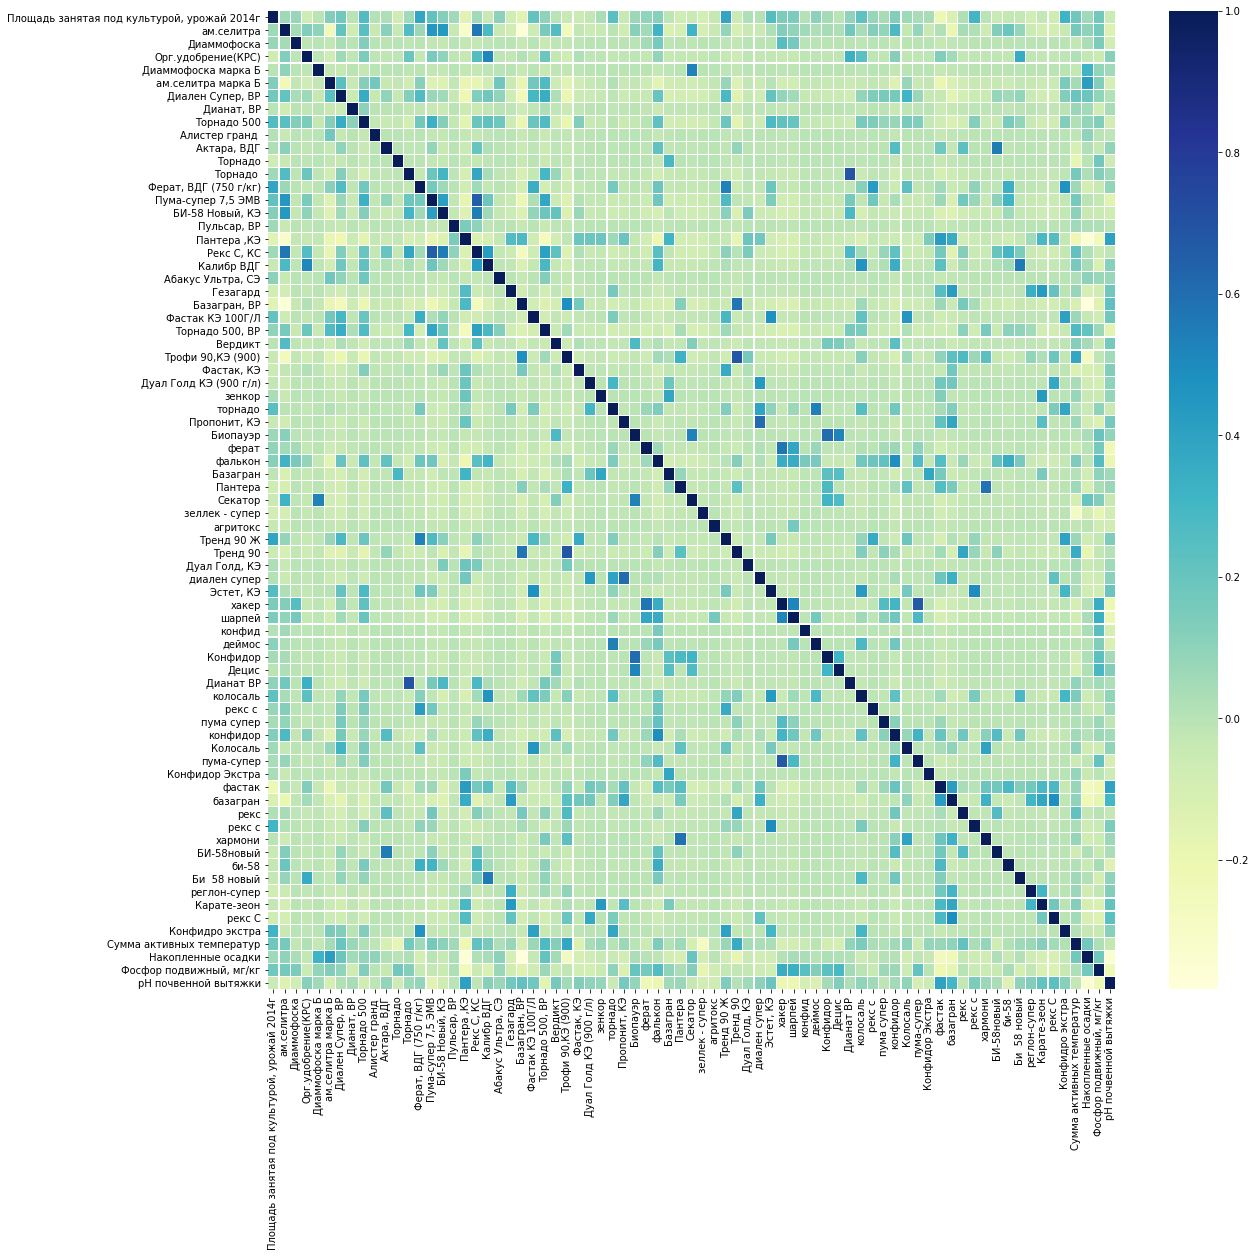

In [58]:
#Посмотрим, как теперь выглядит матрица корреляций
corrmat = df_2014_final.drop(columns = ['Урожайность']).corr()

f, ax = plt.subplots(figsize =(19, 18))

sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1)

In [59]:
#Сделаем линейную регрессию
#Независимые признаки
X = df_2014_final.loc[:, df_2014_final.columns != 'Урожайность']

In [60]:
#Зависимый признак
Y = df_2014_final.loc[ :, ['Урожайность'] ]

In [61]:
model = LinearRegression()

In [62]:
model.fit(X, Y)
y_predict = model.predict(X)

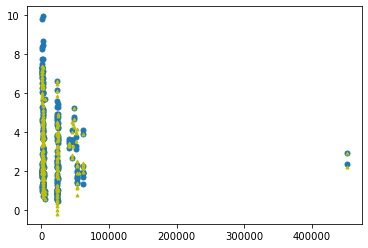

In [63]:
#Оценим качество модели
plt.plot(Y.index, Y, 'o', markersize = 5)
plt.plot(Y.index, y_predict, 'y^', markersize = 3)
plt.show()

In [64]:
print("SRMSE: ", np.sqrt(mean_squared_error(Y, y_predict)))
print("MAE: ", mean_absolute_error(Y, y_predict))
print("R2: ", r2_score(Y, y_predict))

SRMSE:  1.0458039651263993
MAE:  0.6605732337460369
R2:  0.7533052454647093


# Попробуем улучшить

In [65]:
#Проверим модель на робастность
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Average SRMSE:  1.527295361584911
Average MAE:  1.1050193159449313
Average R2:  0.3573016867775483


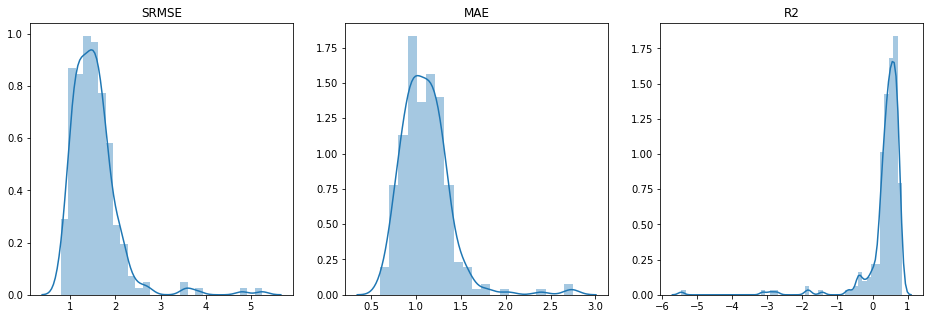

In [84]:
# разбиение выборки на тестовую и обучающую
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, random_state = None)
# инициализация модели (оракула)
model = LinearRegression()
# обучение модели
model.fit(x_train, y_train)
# предсказание
predictions = model.predict(x_test)

from numpy import mean

def model_stats(X,Y,shuffle = 250):
    SRMSE = []
    MAE =  []
    R2 = []
    for i in range(shuffle):
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, random_state = None)
        model = LinearRegression()
        model.fit(x_train, y_train)
        predictions = model.predict(x_test)
        SRMSE.append(np.sqrt(mean_squared_error(y_test, predictions)))
        MAE.append(mean_absolute_error(y_test, predictions))
        R2.append(r2_score(y_test, predictions))
    fig, ax = plt.subplots(1, 3, figsize =(16, 5))
    sns.distplot(SRMSE, ax = ax[0]).set_title("SRMSE")
    sns.distplot(MAE, ax = ax[1]).set_title("MAE")
    sns.distplot(R2, ax = ax[2]).set_title("R2")
    fig.show()
    print("Average SRMSE: ", mean(SRMSE))
    print("Average MAE: ", mean(MAE))
    print("Average R2: ", mean(R2))
    
model_stats(X,Y)

Вывод: не очень хорошо...

In [69]:
#Посмотрим, какие признаки лучше всего коррелируют с урожайностью
good = pd.DataFrame(df_2014_final.corrwith(df_2014_final['Урожайность'])).sort_values(by = 0, ascending = False)
good = good.loc[(good[0] > 0.3) & (good[0] < 1) ].index

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Average SRMSE:  1.5677739753005713
Average MAE:  1.1080353011313726
Average R2:  0.28539879993602424


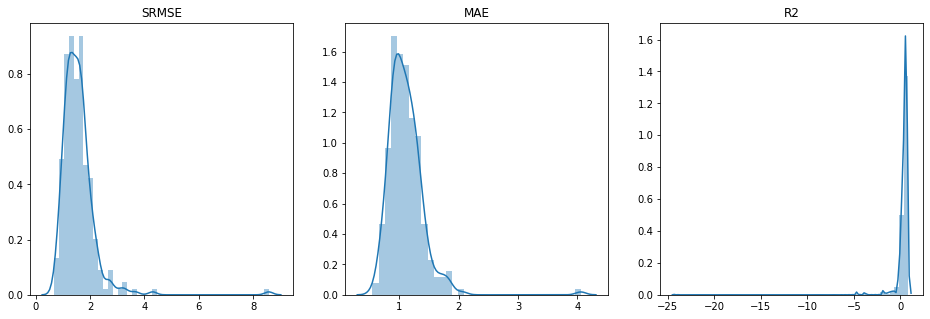

In [70]:
#Попробуем собрать модель из них
X_good = df_2014_final.loc[:, df_2014_final.columns.isin(good)]

x_train, x_test, y_train, y_test = train_test_split(X_good, Y, test_size = 0.1, random_state = None)
model = LinearRegression()
model.fit(x_train, y_train)
predictions = model.predict(x_test)
model_stats(X,Y)


Похоже на то, что было вначале, но, как будто, стало хуже...

Пробуем нормировать исходные данные

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Average SRMSE:  5382613648420.314
Average MAE:  1184092448828.7256
Average R2:  -5.705188371212014e+25


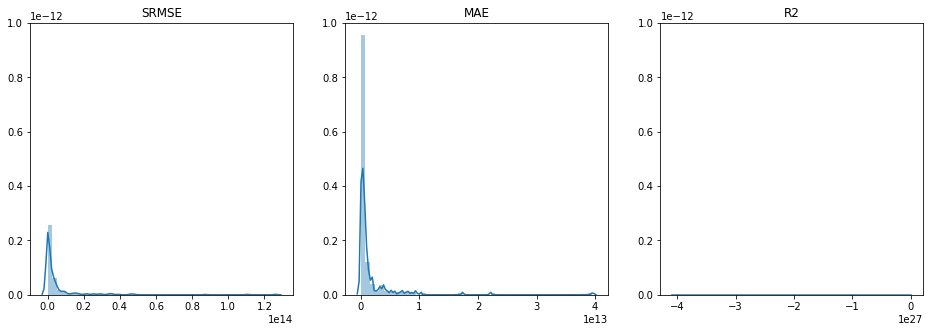

In [71]:
SRMSE = []
MAE =  []
R2 = []
for i in range(250):
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, random_state = None)
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    model = LinearRegression()
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    SRMSE.append(np.sqrt(mean_squared_error(y_test, predictions)))
    MAE.append(mean_absolute_error(y_test, predictions))
    R2.append(r2_score(y_test, predictions))
fig, ax = plt.subplots(1, 3, figsize =(16, 5))
sns.distplot(SRMSE, ax = ax[0]).set_title("SRMSE")
sns.distplot(MAE, ax = ax[1]).set_title("MAE")
sns.distplot(R2, ax = ax[2]).set_title("R2")
fig.show()
print("Average SRMSE: ", mean(SRMSE))
print("Average MAE: ", mean(MAE))
print("Average R2: ", mean(R2))

Пробуем нормировать "хорошие" данные

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Average SRMSE:  1.7384036508300207
Average MAE:  1.3648885781355045
Average R2:  0.2722021408733151


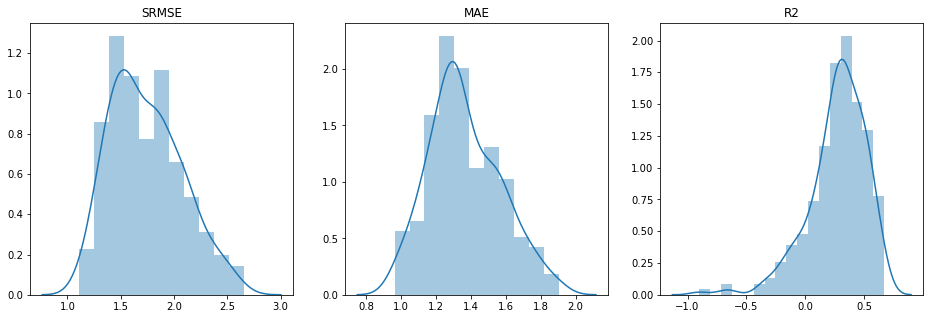

In [72]:
SRMSE = []
MAE =  []
R2 = []
for i in range(250):
    x_train, x_test, y_train, y_test = train_test_split(X_good, Y, test_size = 0.1, random_state = None)
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    model = LinearRegression()
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    SRMSE.append(np.sqrt(mean_squared_error(y_test, predictions)))
    MAE.append(mean_absolute_error(y_test, predictions))
    R2.append(r2_score(y_test, predictions))
fig, ax = plt.subplots(1, 3, figsize =(16, 5))
sns.distplot(SRMSE, ax = ax[0]).set_title("SRMSE")
sns.distplot(MAE, ax = ax[1]).set_title("MAE")
sns.distplot(R2, ax = ax[2]).set_title("R2")
fig.show()
print("Average SRMSE: ", mean(SRMSE))
print("Average MAE: ", mean(MAE))
print("Average R2: ", mean(R2))

После нормировки разброс уменьшился, однако он всё ещё существенный. На графиках видно, что в среднем всё равно получилось хуже, чем изначально, следовательно, затея с "хорошими" признаками не оправдалась. Доверимся автоматике...

In [73]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Average SRMSE:  1.6290331569824517
Average MAE:  1.1341841548812486
Average R2:  0.16564134782682297


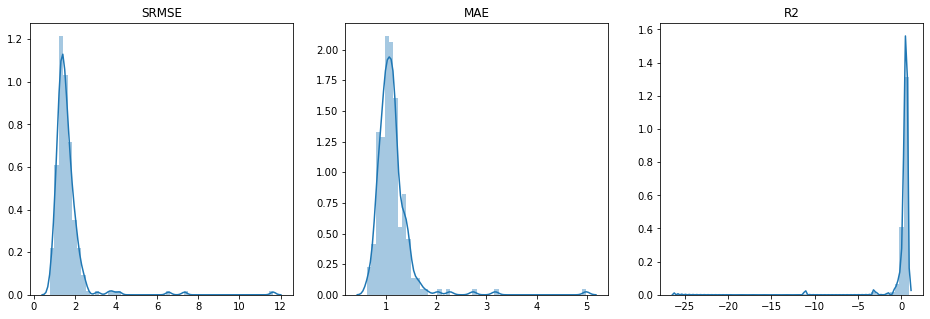

In [74]:
X = df_2014_final.loc[:, df_2014_final.columns != 'Урожайность']
Y = df_2014_final.loc[ :, ['Урожайность'] ]

SRMSE = []
MAE =  []
R2 = []
for i in range(250):
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, random_state = None)
    model = LinearRegression()
    parameters = {'fit_intercept':[True,False], 'normalize':[True,False], }
    grid = GridSearchCV(model, parameters)
    grid.fit(x_train, y_train)
    predictions = grid.predict(x_test)
    SRMSE.append(np.sqrt(mean_squared_error(y_test, predictions)))
    MAE.append(mean_absolute_error(y_test, predictions))
    R2.append(r2_score(y_test, predictions))
fig, ax = plt.subplots(1, 3, figsize =(16, 5))
sns.distplot(SRMSE, ax = ax[0]).set_title("SRMSE")
sns.distplot(MAE, ax = ax[1]).set_title("MAE")
sns.distplot(R2, ax = ax[2]).set_title("R2")
fig.show()
print("Average SRMSE: ", mean(SRMSE))
print("Average MAE: ", mean(MAE))
print("Average R2: ", mean(R2))

Всё равно не то. Пробуем PCA.

In [75]:
from sklearn.decomposition import PCA

In [76]:
pca = PCA(n_components = 3)
pca.fit(df_2014_final.loc[:, df_2014_final.columns != 'Урожайность'])
print(pca.explained_variance_ratio_)

[0.67245268 0.28211388 0.03131606]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Average SRMSE:  1.9393773060439499
Average MAE:  1.5716164840368148
Average R2:  0.06253801525240459


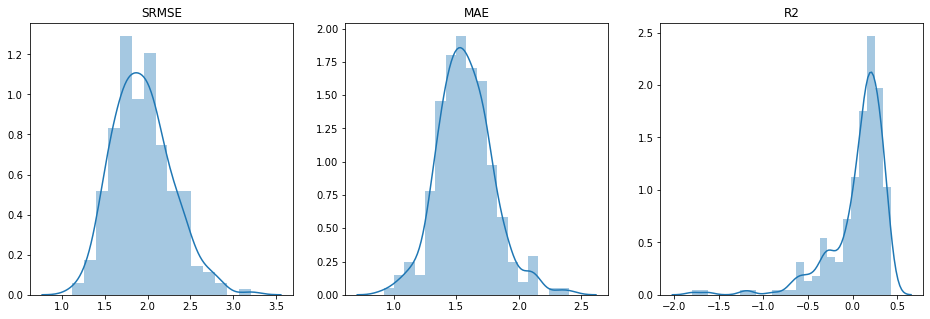

In [77]:
new_dim_df = pd.DataFrame(PCA(n_components = 3).fit_transform(df_2014_final.loc[:, df_2014_final.columns != 'Урожайность']))
X = new_dim_df
Y = df_2014_final.loc[ :, ['Урожайность'] ]

SRMSE = []
MAE =  []
R2 = []
for i in range(250):
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, random_state = None)
    model = LinearRegression()
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    SRMSE.append(np.sqrt(mean_squared_error(y_test, predictions)))
    MAE.append(mean_absolute_error(y_test, predictions))
    R2.append(r2_score(y_test, predictions))
fig, ax = plt.subplots(1, 3, figsize =(16, 5))
sns.distplot(SRMSE, ax = ax[0]).set_title("SRMSE")
sns.distplot(MAE, ax = ax[1]).set_title("MAE")
sns.distplot(R2, ax = ax[2]).set_title("R2")
fig.show()
print("Average SRMSE: ", mean(SRMSE))
print("Average MAE: ", mean(MAE))
print("Average R2: ", mean(R2))

Тоже безуспешно.

In [80]:
from sklearn import feature_selection

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Average SRMSE:  1.5403232662530562
Average MAE:  1.097180043340107
Average R2:  0.42313259147552623


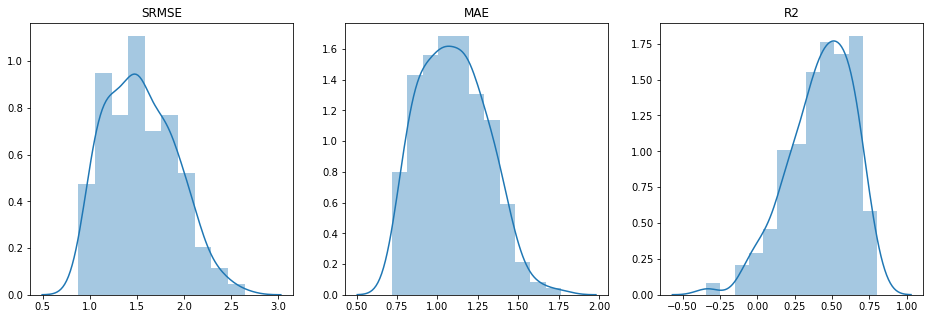

In [82]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
X_new = SelectKBest(f_regression, k=8).fit_transform(df_2014_final.loc[:, df_2014_final.columns != 'Урожайность'], 
                                            df_2014_final.loc[ :, ['Урожайность'] ])

model_stats(X_new,Y)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Average SRMSE:  1.982265175265516
Average MAE:  1.5979203072602035
Average R2:  0.06385376599290453


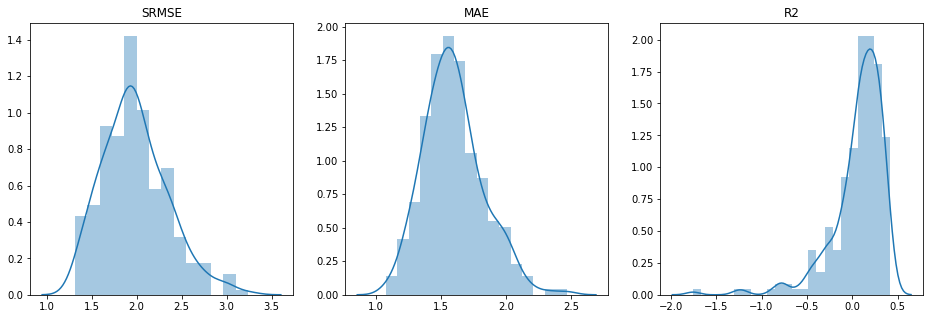

In [83]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

X = df_2014_final.loc[:, df_2014_final.columns != 'Урожайность']
Y = df_2014_final.loc[ :, ['Урожайность'] ]
lsvc = Lasso(alpha=1).fit(X, Y) #чем больше альфа, тем меньше признаков выбирается 
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)

model_stats(X_new, Y)

Пробуем backward elimination

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Average SRMSE:  1.3261634377403047
Average MAE:  0.9175700174174742
Average R2:  0.5425892380345321


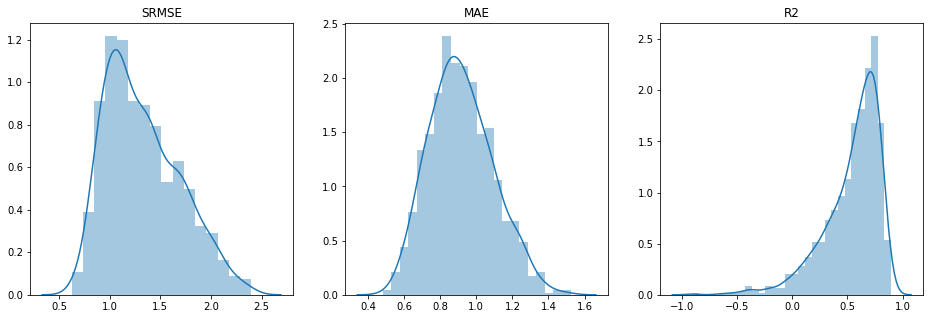

In [85]:
import statsmodels.api as sm

X = df_2014_final.loc[:, df_2014_final.columns != 'Урожайность'].astype(float)
Y = df_2014_final.loc[ :, ['Урожайность'] ]
significance_level = 0.05

features = X.columns.tolist()
while(len(features)>0):
    features_with_constant = sm.add_constant(X[features])
    p_values = sm.OLS(Y, features_with_constant).fit().pvalues[1:]
    max_p_value = p_values.max()
    if(max_p_value >= significance_level):
        excluded_feature = p_values.idxmax()
        features.remove(excluded_feature)
    else:
        break 

X = X[features]
model_stats(X,Y,1000)

Кандидат на победу!

In [89]:
features

['ам.селитра',
 'Диаммофоска марка Б',
 'ам.селитра марка Б',
 'Диален Супер, ВР',
 'Ферат, ВДГ (750 г/кг)',
 'Пума-супер 7,5 ЭМВ',
 'Пантера ,КЭ',
 'ферат',
 'Пантера',
 'Тренд 90 Ж',
 'Эстет, КЭ',
 'фастак',
 'рекс С',
 'Сумма активных температур',
 'Накопленные осадки',
 'pН почвенной вытяжки',
 'Органическое вещество, %']